#Imports and first inizializations

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import re
import csv
import sys
import random
import numpy as np
import pandas as pd
from itertools import islice
from bs4 import BeautifulSoup
from string import punctuation
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt


Inizialization of ntlk sets, used for filtering e tagging

In [5]:
nltk.download('punkt')  
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
device = "cuda"
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'

np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
general_path = '/content/drive/MyDrive/Colab Notebooks/data/FDSProject'

fake_path = os.path.join(general_path, "Fake.csv")
true_path = os.path.join(general_path, "True.csv")
# fake_prep = os.path.join(general_path, "fake.token")
# true_prep = os.path.join(general_path, "true.token")
glove_path = os.path.join(general_path, "glove.6B.50d.txt")  # 50d is enough 
csv_path = os.path.join(general_path, "tests.csv")

# Read Data

Data reading trough csv library.
Labeled fake article with 1 and true article with 1

In [8]:
fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

In [9]:
fake_df['label'] = 1
true_df['label'] = 0

Excluded every coloum except title and corpus, we then concat the two coloumns.

In [10]:
news_df = pd.concat([true_df, fake_df])
news_df['sentence'] = news_df['title'] + ' ' + news_df['text']
news_df['pos'] = news_df['title'] + ' ' + news_df['text']
news_df = news_df.filter(['sentence', 'pos', 'label'])


Shuffled the dataset

In [11]:
news_df = news_df.sample(frac=1).reset_index(drop=True)

# Preprocessing

In [12]:
stop_tokens = set(stopwords.words('english'))
punc_tokens = set(punctuation)
stop_tokens.update(punc_tokens)

Started preprocessing and filtered the articles: deleted the stopwords and punctuation.
Added lemmatization and pos tagging

In [13]:
news_df.sentence = [word_tokenize(row.sentence) for indx, row in news_df.iterrows()]

In [14]:
news_df.sentence = [[token for token in article if not token in stop_tokens] for article in news_df.sentence]

In [15]:
lemmatizer = WordNetLemmatizer() 
news_df.sentence = [[lemmatizer.lemmatize(token) for token in article] for article in news_df.sentence]

In [16]:
from nltk.corpus import wordnet as wn
def penn_to_wn(tag):
    if tag in ['JJ', 'JJR', 'JJS']:
        return wn.ADJ
    elif tag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wn.NOUN
    elif tag in ['RB', 'RBR', 'RBS']:
        return wn.ADV
    elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wn.VERB
    return None

def my_lemmatize(t):
    pos = penn_to_wn(t[1])
    if pos != None:
        return lemmatizer.lemmatize(t[0].lower(),penn_to_wn(t[1])),t[1]
    else:
        return lemmatizer.lemmatize(t[0].lower()),t[1]

In [17]:
for article in news_df.sentence:
    print(article)
    break
lemmatizer = WordNetLemmatizer() 
sent = []
poses = []
for article in news_df.sentence:
    lemmatized,poss = [],[]
    tuples = nltk.pos_tag(article)
    for t in tuples:
        lemma, pos = my_lemmatize(t)
        lemmatized.append(lemma)
        poss.append(pos)
    sent.append(lemmatized)
    poses.append(poss)

news_df.sentence = sent
news_df.pos = poses


['RUBIO', 'Sides', 'With', 'Democrats', 'On', 'Giving', 'A', 'Whopping', '2', 'Billion', 'For', 'Zika', 'Virus', 'Prevention', 'Democrats', 'want', 'spend', 'whopping', '2', 'billion', 'zika', 'virus', 'prevention', 'Republicans', 'demanding', 'control', 'Rubio', 'calling', 'stingy', 'federal', 'dollar', 'Is', 'guy', 'really', 'Republican', 'Just', 'two', 'month', 'running', 'one', 'conservative', 'candidate', 'GOP', 'presidential', 'race', 'Sen.', 'Marco', 'Rubio', 'embracing', 'Democrats', 'call', 'open', 'federal', 'checkbook', 'dole', 'billion', 'dollar', 'money', 'combat', 'Zika', 'virus', 'tacking', 'onto', 'debt.Mr', 'Rubio', 'whose', 'home', 'state', 'Florida', 'risk', 'serious', 'outbreak', 'co-sponsoring', 'legislation', 'fully', 'fund', 'President', 'Obama', 'nearly', '2', 'billion', 'emergency', 'spending', 'request', 'blasted', 'fellow', 'Republicans', 'stingy', 'demanding', 'proof', 'controls.And', 'Mr.', 'Rubio', 'finishing', 'first', 'term', 'ditching', 'Senate', 'end',

Inizialized splitting value. In our case we splitted the dataset in 80-20, where 80 is the training dataset

In [18]:
training_items = int(news_df.shape[0]*.8)

In [19]:
train = news_df[:training_items]
test = news_df[training_items:]

In [20]:
def data_prep(dataset):
  return [{'lemmas': row.sentence,'pos':row.pos, 'label': row.label} for indx, row in dataset.iterrows()]

In [21]:
train = data_prep(train)
test = data_prep(test)

## Vocab2Id

In [22]:
vocab2ids = {
    'lemmas': {},
    'pos': {}
}

In [23]:
# Create Vocab to Ids for features
# Given the feature, it extracts all unique values and assigns an id to each one
def vocab2id_builder(dataset,feature):

  words = [word for article in dataset for word in article[feature]] 
  words = list(set(words))

  words.append(UNK_TOKEN)
  words.append(PAD_TOKEN)

  vocab2id = {v:i for i, v in enumerate(words)}

  return vocab2id

In [24]:
vocab2ids['lemmas'] = vocab2id_builder(train, 'lemmas')
vocab2ids['pos'] = vocab2id_builder(train,'pos')

In [25]:
# Save the Dictionary
import pickle

#with open(os.path.join(general_path, "vocab2id"), 'wb') as fp:
#   pickle.dump(vocab2ids, fp)

In [26]:
# Load the Dictionary
with open(os.path.join(general_path, "vocab2id"), 'rb') as fp:
  vocab2ids = pickle.load(fp)

## Read & Create GloVe

In [27]:
words = []
id = 0
word2id = {}
vectors = []

with open(glove_path, 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2id[word] = id
        id += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)

In [28]:
poss = set()
pos_id = 0
pos2id = {}
pos_vectors = []
for part in vocab2ids['pos']:
    id = vocab2ids['pos'][part]
    poss.add(part)
    if part not in pos2id:
        pos2id[part] = id
        vect = torch.rand(20)
        pos_vectors.append(vect)

In [29]:
glove = {w: vectors[word2id[w]] for w in words}
pos_embeds = {p: pos_vectors[pos2id[p]] for p in poss}

In [30]:
glove['also']

array([ 0.352   ,  0.25323 , -0.097659,  0.26108 ,  0.12976 ,  0.33684 ,
       -0.73076 , -0.42641 , -0.22795 , -0.083619,  0.52963 ,  0.34644 ,
       -0.32824 , -0.28667 ,  0.24876 ,  0.22053 ,  0.019356, -0.015447,
       -0.18319 , -0.29729 ,  0.11739 , -0.071214,  0.41086 ,  0.013912,
       -0.17424 , -1.5839  , -0.051961, -0.18115 , -0.76375 , -0.17817 ,
        3.749   , -0.045559,  0.10721 , -0.51313 ,  0.25279 , -0.051714,
        0.31911 ,  0.28    , -0.19937 ,  0.17819 ,  0.018623,  0.47641 ,
       -0.15655 , -0.38287 ,  0.26989 , -0.011186, -0.7244  ,  0.036514,
       -0.011489, -0.025882])

# Hparams

In [31]:
#inizialized embedding weights
embedding_weights = {
    'lemmas':{},
    'pos':{}
}

In [32]:
class HParams():

  vocab_size = len(embedding_weights)
  hidden_dim = 64
  embedding_dim = 70
  num_classes = 2
  bidirectional = True
  num_layers = 1
  dropout = 0.0
  embedding_weights = embedding_weights
  epochs = 15
  max_length = 300
  batch_size = 64
  learning_rate = 0.001 #default 0.001

params = HParams()

In [33]:
class HParamsD():

    vocab_size = len(embedding_weights)
    hidden_dim = 128
    embedding_dim = 70
    num_classes = 2
    bidirectional = True
    num_layers = 1
    dropout = 0.2
    embedding_weights = embedding_weights


    hidden_dim2 = 64
    num_layers2 = 1
    dropout2 = 0.1


    epochs = 20
    max_length = 300
    batch_size = 64
    learning_rate = 0.0005 #default 0.001

#inizialized params for deep  lstm
params = HParamsD()

# Batching

In [34]:
lengths = [len(article.sentence) for indx, article in news_df.iterrows()]

In [35]:
# Check whether the word is in the Dictionary or not
# If the word is not in the Dict, replace it with the unknown token
def vocab_checker(vocab2id, item):
  if item in vocab2id:
    return vocab2id[item]
  else:
    return vocab2id[UNK_TOKEN]

In [36]:
max_length = params.max_length

In [37]:
#create batches, Added padding for article smaller then the max limit
def create_batches(dataset, batch_size):
  batched_dataset = []

  for i in range(0, len(dataset), batch_size):
    batch = dataset[i:i+batch_size]
    key_batch = {}

    for k in dataset[0].keys():
      x = [row[k] for row in batch]
      if k == 'label':
        key_batch[k] = torch.tensor(x).to(device)
        continue

      max_batch_len = max([len(xx) for xx in x])
      x = [xx+[PAD_TOKEN]*(max_length-len(xx)) if len(xx) < max_length else xx[:max_length] for xx in x]
      key_batch[k] = torch.tensor([[vocab_checker(vocab2ids[k], xxx) for xxx in xx] for xx in x]).to(device)
  
    batched_dataset.append(key_batch)
     
  return batched_dataset

In [38]:
train_batch = create_batches(train, params.batch_size)
test_batch = create_batches(test, params.batch_size)

# Create Weights

In [39]:
def embedding_weights_generator(glove, vocab2ids, feature, emb_len):
  matrix_len = len(vocab2ids[feature])
  weights_matrix = np.zeros((matrix_len, emb_len))

  for k, v in vocab2ids[feature].items():
    try: 
      weights_matrix[v] = glove[k]
    except KeyError:
      weights_matrix[v] = np.random.normal(scale=0.6, size=(emb_len, ))
      
  return torch.tensor(weights_matrix, dtype=torch.float32).to(device)

In [40]:
embedding_weights['lemmas'] = embedding_weights_generator(glove, vocab2ids, 'lemmas', emb_len=50)
embedding_weights['pos'] = embedding_weights_generator(pos_embeds, vocab2ids, 'pos', emb_len=20)

In [41]:
# Save weights
with open(os.path.join(general_path, "embedding_w2"), 'wb') as fp:
  pickle.dump(embedding_weights, fp)

# LSTM Models

## Shallow Model

In [42]:
from pprint import pprint

In [43]:
class ShallowLSTM(nn.Module):

  def __init__(self, hparams):
    super(ShallowLSTM, self).__init__()


    self.lemmas_embedding = nn.Embedding.from_pretrained(hparams.embedding_weights['lemmas'], freeze=False)
    self.pos_embedding = nn.Embedding.from_pretrained(hparams.embedding_weights['pos'], freeze=False)


    self.lstm = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                        bidirectional=hparams.bidirectional,
                        num_layers=hparams.num_layers, 
                        dropout = hparams.dropout,
                        batch_first = True)

    lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2

    self.dropout = nn.Dropout(hparams.dropout)
    self.classifier = nn.Linear(lstm_output_dim, hparams.num_classes)

    self.hidden_cell = (torch.zeros(1,1,hparams.hidden_dim),
                        torch.zeros(1,1,hparams.hidden_dim))
    
  def forward(self, src):
    lemmas = src['lemmas']
    pos = src['pos']
    lemmas_emb = self.lemmas_embedding(lemmas)
    pos_emb = self.pos_embedding(pos)
    embs = torch.cat([lemmas_emb, pos_emb], dim=-1)
    o, (h, c) = self.lstm(embs)
    o = self.dropout(o[:, -1])
    output = self.classifier(o)
    
    return output

## Deep Model

In [44]:
class DeepLSTM(nn.Module):

  def __init__(self, hparams):
    super(DeepLSTM, self).__init__()

    self.lemmas_embedding = nn.Embedding.from_pretrained(hparams.embedding_weights['lemmas'], freeze=True)
    self.pos_embedding = nn.Embedding.from_pretrained(hparams.embedding_weights['pos'], freeze=False)


    self.lstm1 = nn.LSTM(hparams.embedding_dim, hparams.hidden_dim, 
                        bidirectional=hparams.bidirectional,
                        num_layers=hparams.num_layers, 
                        dropout = hparams.dropout,
                        batch_first = True)
    
    lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2

    
    self.lstm2 = nn.LSTM(lstm_output_dim, hparams.hidden_dim2, 
                        bidirectional=hparams.bidirectional,
                        num_layers=hparams.num_layers2, 
                        dropout = hparams.dropout2,
                        batch_first = True)

    lstm_output_dim2 = hparams.hidden_dim2 if hparams.bidirectional is False else hparams.hidden_dim2 * 2


    self.dropout = nn.Dropout(hparams.dropout)
    self.dropout2 = nn.Dropout(hparams.dropout2)


    self.projection_layer = nn.Sequential(nn.Linear(lstm_output_dim2, 32), 
                                          nn.ReLU(),
                                          nn.Linear(32, 16),
                                          nn.ReLU(),
                                          nn.Linear(16, hparams.num_classes))
                              

  
  def forward(self, src):
    
    lemmas = src['lemmas']
    pos = src['pos']
    lemmas_emb = self.lemmas_embedding(lemmas)
    pos_emb = self.pos_embedding(pos)
    embs = torch.cat([lemmas_emb, pos_emb], dim=-1)
    o, (h, c) = self.lstm1(embs)
    o = self.dropout(o)
    o2, (h2, c2) = self.lstm2(o)
    o2 = self.dropout2(o2[:, -1])
    output = self.projection_layer(o2)

    return output

# Trainer Class

In [45]:
class Trainer():

  def __init__(
    self,
    model: nn.Module,
    loss_function,
    optimizer):

    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.historyloss = {'train' :[], 'val':[]}

  def train(self, train_dataset, 
            valid_dataset, 
            epochs):

    train_loss = 0.0
    for epoch in range(epochs):
      print(f'Epoch {epoch+1}')

      epoch_loss = 0.0
      self.model.train()

      for step, sentence in enumerate(train_dataset):
        tokens = {
            'lemmas': sentence['lemmas'],
            'pos': sentence['pos']
        }

        labels = {
            'label': sentence['label']
        }

        self.optimizer.zero_grad()
        predictions = self.model(tokens)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels['label'].view(-1)
        
        temp_loss = self.loss_function(predictions, labels)

        temp_loss.backward()
        self.optimizer.step()

        epoch_loss += temp_loss.tolist()

        
      avg_epoch_loss = epoch_loss / len(train_dataset)
      train_loss += avg_epoch_loss

      print(f'\t[Epoch: {epoch+1}] Training Loss = {avg_epoch_loss}')
      valid_loss = self.evaluate(valid_dataset)
      print(f'\t[Epoch: {epoch+1}] Validation Loss = {valid_loss}')
      
      
      self.historyloss['train'].append(avg_epoch_loss)
      self.historyloss['val'].append(valid_loss)



    print('Training has finished')
    
    avg_epoch_loss = train_loss / epochs

    return avg_epoch_loss
  

  def evaluate(self, valid_dataset):

    valid_loss = 0.0
    self.model.eval()

    with torch.no_grad():
      for sentence in valid_dataset:
        tokens = {
            'lemmas': sentence['lemmas'],
            'pos': sentence['pos']

        }

        labels = {
            'label': sentence['label']
        }

        predictions = self.model(tokens)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels['label'].view(-1)
        temp_loss = self.loss_function(predictions, labels)
        valid_loss += temp_loss.tolist()
      
    return valid_loss / len(valid_dataset)


  def predict(self, x):

    self.model.eval()
    
    with torch.no_grad():
        logits = self.model(x)
        predictions = torch.argmax(logits, -1)
        return logits, predictions

# Train LSTM Model

In [46]:
base_model = DeepLSTM(params).cuda()
base_model

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


DeepLSTM(
  (lemmas_embedding): Embedding(195191, 50)
  (pos_embedding): Embedding(41, 20)
  (lstm1): LSTM(70, 128, batch_first=True, dropout=0.2, bidirectional=True)
  (lstm2): LSTM(256, 64, batch_first=True, dropout=0.1, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (projection_layer): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=2, bias=True)
  )
)

The next code block is for loading the model. Is optional and the model can be directly trained by decommenting the "trainer.train" block

In [47]:

model_load_name = 'Twolayers_FDS_Model.pth'
path = f"/content/drive/MyDrive/Colab Notebooks/data/FDSProject/{model_load_name}" 
base_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [48]:
trainer = Trainer(
    model = base_model,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = optim.Adam(base_model.parameters(), lr=params.learning_rate),
)

In [60]:
trainer.evaluate(test_batch)

0.0022682850885564435

# Evaluation

In this section we calculate all the scores and the plot

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import seaborn as sns

In [62]:
def f_score(labels, predictions):
  
  print(f'# instances: {len(labels)}')

  flat_pred = [xx for x in predictions for xx in x]
  flat_label = [xx for x in labels for xx in x]

  len(flat_pred)
  len(flat_label)
  

  p = precision_score(flat_label, flat_pred)
  r = recall_score(flat_label, flat_pred)
  f = f1_score(flat_label, flat_pred)
  print(f'# precision: {p:.4f}')
  print(f'# recall: {r:.4f}')
  print(f'# f1: {f:.4f}')
  return p, r , f

In [63]:
import matplotlib.pyplot as plt

In [64]:
def cm_plot(test_label, pred_labels):

  label=[0, 1]
  flat_pred = [xx for x in pred_labels for xx in x]
  flat_label = [xx for x in test_label for xx in x]

  cm = confusion_matrix(flat_label, flat_pred, label)
  print(cm)

  sum_col_cm = np.sum(cm, axis=1, keepdims=True)
  acc_col_cm = (cm / sum_col_cm.astype(float))

  acc_col_cm = [[round(x, 4) for x in xx] for xx in acc_col_cm]
  acc_df = pd.DataFrame(data=acc_col_cm, index=label, columns=label)

  acc_df.index.name = 'ACTUAL LABELS'
  acc_df.columns.name = 'PREDICTED LABELS'
  fig, ax = plt.subplots(figsize=(8,6))
  sns.heatmap(acc_df, annot=acc_col_cm, annot_kws={"size": 15}, fmt='', ax=ax, cmap="YlGnBu")
  plt.show()

In [65]:
predictions = []
test_labels = []

for sentences in test_batch:
  tokens = {
      'lemmas': sentences['lemmas'],
      'pos': sentences['pos']
  }

  logits, predicts = trainer.predict(tokens)
  predictions.append(predicts) 
  test_labels.append(sentences['label'])

In [66]:
test_labels = [item.cpu().numpy() for item in test_labels]
predictions = [item.cpu().numpy() for item in predictions]

In [67]:
pr, re, fu = f_score(test_labels, predictions)

# instances: 141
# precision: 0.9996
# recall: 0.9998
# f1: 0.9997


[[4314    2]
 [   1 4663]]


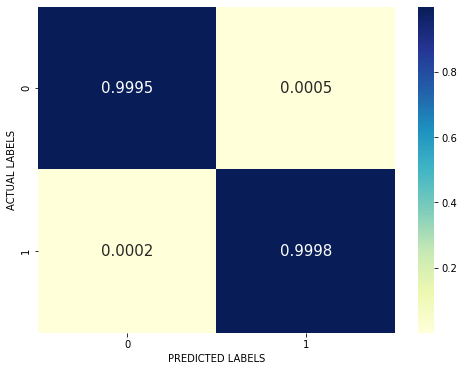

In [68]:
cm_plot(test_labels, predictions)

The last block is used to save the model into drive

In [ ]:
'''
model_save_name = 'lstm_model_fakenewsdetection.pth'
path = f"/content/drive/MyDrive/Colab Notebooks/data/FDSProject/{model_save_name}" 
torch.save(base_model.state_dict(), path)
'''